# Detection and Quantification of Microspots

---

**Updated on:** 2023-12-22

> Authors: Simon Knoblauch (simon.knoblauch@student.uni-tuebingen.de)  
> Input file(s): .tif, .png, .jpg
> Images must contain visible circular wells or spots arranged in a grid  
> Output file(s): .csv file containing data on all detected spots

**Please read the comments before proceeding to run the code of each cell and let us know if you run into any errors or find undocumented pieces of code.**

In [8]:
# Importing dependencies
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
import numpy as np
from pathlib import Path
import sys
sys.path.append(r"..")
import microspot_reader as msu
import microspot_reader.plots as plots
%matplotlib widget


## User Input

Please input the filepath of the image you would like to analyze into `inputfile` as well as the path to the output folder into `outputfolder`.

In order to be able to merge multiple datasets containing data on the same LC-MS experiment (multiple assays per microfluidic device for example), please input the index of the top left (`first_spot`) and bottom right (`last_spot`) spot or well contained by the image correctly.
If there exist columns or rows of spots in the image that do not contain any data from the LC-MS experiment, (For example if you skipped a row or column) add the index of that column to either `empty_rows` (for rows) or `empty_cols` (for columns).

Spots to be used for normalization purposes should be added to the list `control_spots`. Please add them as a String with the letter in capital letters.

In [9]:
inputfile=Path(r"../example_files/part1_a1-l11.tif")
outputfolder=Path(r"../output")

first_spot="A1"
last_spot="L11"

empty_rows=[]
empty_cols=[1]

control_spots=["A1","B1","C1","D1","E1","F1","G1","H1","I1","J1","K1","L1"]

### Extracting Information from User Input

In [10]:
# Dictionaries to convert Row-Letters into Row-Numbers and vice versa.
row_conv={"abcdefghijklmnopqrstuvwxyz"[i-1]: i for i in range(1,27)}
row_conv_inv={v:k for k,v in row_conv.items()}

grid_props=msu.conv_gridinfo(first_spot,last_spot,row_conv)

## Loading the Image File

Here a grayscale version of the loaded image is displayed. If you want to invert the image colors for following analysis, please set the `invert` argument of the `prep_img` function to `True` otherwise set it to `False`.

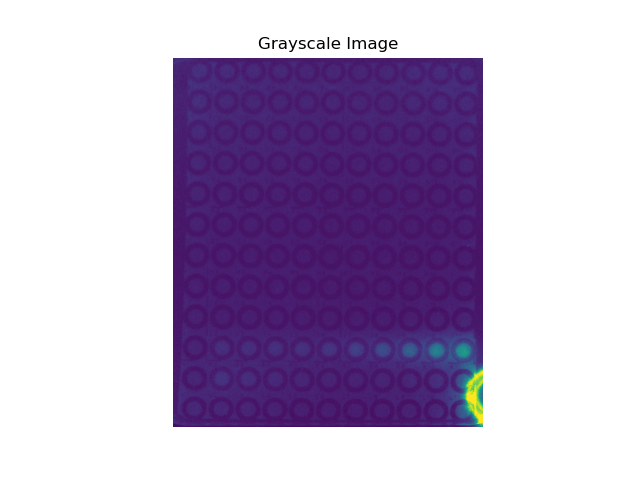

In [11]:
# Load and prepare raw image file.
raw_img=msu.prep_img(inputfile, invert=True)

# Display the grayscale image using the "viridis" colormap.
fig,ax=plt.subplots()
ax.imshow(raw_img)
ax.axis("off")
ax.set(title="Grayscale Image");

## Inital Spot and Grid detection

In this step the initial spot detection is performed and a grid is layed onto all detected spots to correct for missing spots and artefacts of the detection algorithm. 
For initial spot detection it is important that the arguments `hough_minx` (minimum distance of spots in x direction), `hough_miny` (minimum distance of spots in y direction), `small_rad` (smallest tested radius of spots in pixels) and `large_rad` (largest tested radius of spots in pixels) of the `msu.spot.detect` method all match the image that you want to analyze. For one experimental setup this generally only has to be checked once. You can do this by hovering over the displayed version of the loaded image above and checking the coordinates of a spots center to its edge and the distance between two spots in x and y direction. The algorithm generally underestimates the radius of spots so set `small_rad` to a value slightly lower than you expect.

For noisy images the other settings of the method can also be tweaked to yield better results. All arguments containing the word ***canny*** are used for edge detection. The detected edges of the images are plotted next to the grid below this cell. it is important to check whether the edges clearly show circles. If that is not the case lower the thresholds for canny edge detection first. Note that the `canny_lowthresh` argument only accepts values *lower or equal* to the value of `canny_highthresh`.

For grid detection (`msu.gridline.detect`) only 3 arguments exist. The most important one is `min_dist`. Which defines the minimum distance 2 gridlines can have from each other. This should be very similar to the distances of spots to each other. Generally the value can be restricted a bit more than the ones for spot detection. The reduce the amount of artifacts, a maximum tilt of the grid can be defined in `max_tilt`. The lower the maximum tilt is the closer the grid has to be aligned with the primary axes of the image. The more relaxed the maximum tilt becomes, the more likely it is to see artifacts. We found that a tilt of around 4-5 degrees yiels good results. If not all gridlines are detected we suggest first reducing the minimum distance between the gridlines before lowering the detection threshold with the `threshold` argument.

Please cross-check if the grid detection worked properly by inspecting the plot below. If there is an intersection of gridlines on all spots, grid detection worked properly and you can continue with the next steps.

array([<Axes: >, <Axes: >], dtype=object)

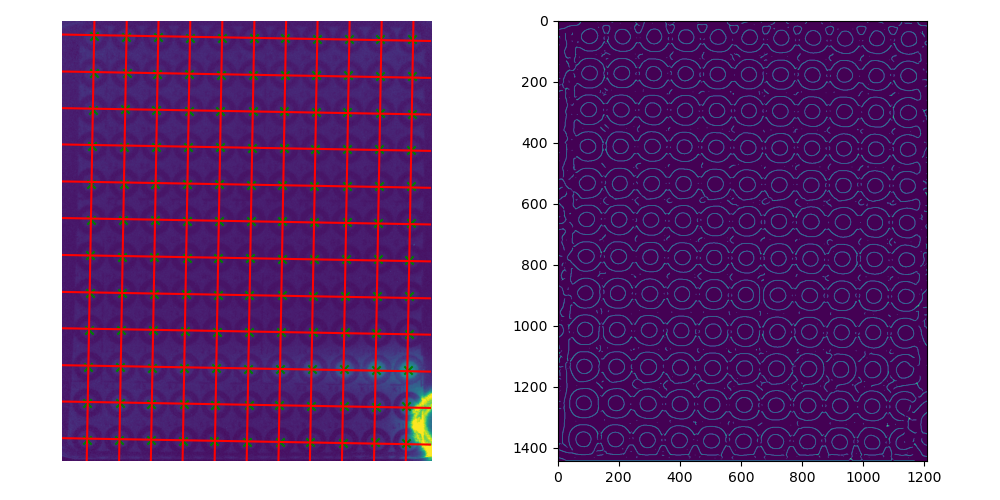

In [12]:
# Inital spot-detection.
init_spots,test=msu.spot.detect(
    gray_img=raw_img,
    spot_nr=grid_props["spot_nr"],
    canny_sig=10,
    canny_lowthresh=0.001,
    canny_highthresh=0.001,
    hough_minx=70,
    hough_miny=70,
    hough_thresh=0.3,
    small_rad=20,
    large_rad=30,
    troubleshoot=True
    )

avg_spotradius=np.mean([s.rad for s in init_spots])

# Create an empty image and draw a dot for each detected spot.
dot_img=np.zeros(raw_img.shape)
for i_spot in init_spots: 
    i_spot.draw_spot(dot_img,255,5)

# Detection of gridlines.
gridlines=msu.gridline.detect(
    img=dot_img,
    max_tilt=5,
    min_dist=75,
    threshold=0.2
    )

hor_line=[line for line in gridlines if line.alignment=="hor"]
vert_line=[line for line in gridlines if line.alignment=="vert"]

# Calculate the intersections of all horizontal lines with all vertical lines.
grid_points=[]
for h_l in hor_line:
    for v_l in vert_line:
        grid_points.append(v_l.intersect(h_l))

# Display the grid.
fig,ax=plt.subplots(1,2,figsize=(10,5))
plots.plot_grid(fig,ax[0],raw_img,hor_line+vert_line)
for s in init_spots:
    ax[0].scatter(s.x,s.y, c="green", marker="x")
ax[1].imshow(test["edge"])
ax

## Spot Correction, Sorting and Intensity Determination

For this step only one setting should be tweaked: `max_distance`. This gives to the maximum distance a detected spot can have from the detected grid in pixels to still be considered a valid spot. Any spot further away from the grid will be removed and any gridpoint that is not associated with a spot already will have a spot backfilled with the average radius of spots during initial spot detection. The smaller the max distance is, the more spots must adhere to the detected grid, this can be good if the grid detection is very reliable for the image. However initial spot detection can be better at finding the real center of a spot, which leads to a higher accuracy for the determination of the spot intensity. For our system a maximum distance of 10 pixels was found to work well.

In [13]:
max_distance=10

# Initializing corrected spotlist
corr_spots=[]

# Loop over all spots and gridpoints
for s_point in init_spots:
    dist_list=[]
    for g_point in grid_points:

        # Calculate the distance between the points and append it to the running list.
        pointdist=g_point.eval_distance(s_point.x,s_point.y)
        dist_list.append(pointdist)
    
    # If the distance between the current spot and any gridpoint is <= it is accepted as correct.
    if min(dist_list)<=max_distance:
        corr_spots.append(s_point)

# Loop over all gridpoints and backfill the ones that are not associated with a spot. The spots are backfilled with the average radius for spots during initial detection
for g_point in grid_points:
    if g_point.min_dist>max_distance:
        msu.spot.backfill(corr_spots,g_point.x,g_point.y,avg_spotradius)

sort_spots=msu.spot.sort_grid(corr_spots,
                            row_conv=row_conv_inv,
                            row_start=grid_props["rows"]["bounds"][0],
                            col_start=grid_props["columns"]["bounds"][0])

for s in sort_spots:
    s.get_intensity(raw_img)
    
    # Give spots no label if they do not contain sample
    if s.row_name in empty_rows or s.col in empty_cols:
        s.type=np.nan
    
    # Label spots as control.
    if s.row_name+str(s.col) in control_spots:
        s.type="Control"

## Halo Detection

Halo detection (`msu.halo.detect`) is an optional step of the workflow. It is only needed if there are anitmicrobial halos visible in the image. If you do not wish to perform halodetection, comment this cell out or skip this cell during analysis.

The quality of halo detection really depends on the image quality and is very sensitive to changes in the settings.

A range of radii that should be tested must be input via `min_rad` (smallest tested radius in pixels) and `max_rad` (largest tested radius in pixels). Generally the lower input should be slightly higher than the radius of the spots themselves. The minimum distance in x and y direction (`min_xdist` and `min_ydist`) can take values similar to initial spot detection. It is also possible to lower the distance significantly as halos are already restricted to the location of spots in the images. This may lead to more false positive halos but can increase the reliability of halo detection if a proper value is found.

Another way to increase the reliability of halo detection is by increasing the `dil_disk` argument. This argument essentially defines the thickness of the halo skeleton after image processing. The thicker the halo skeleton the more likely it will be detected but the less accurate the determination of the radius becomes. The two settings we found work best are `3` for more reliable radius detection and `10` for more reliable halo detection.

After the halos have been detected they are assigned to a spot based on a distance criterium set by the `dist_thresh` agrument of the `assign_halo` method. The larger this distance criterium is, the higher the likelyhood of detecting halos for a given spot. However the likelyhood of the detected halo being an artifact also increases. A decent approximation of a good distance criterium is half the maximum radius used during spot detection.


2023-12-22 12:32:56.190 No runtime found, using MemoryCacheStorageManager


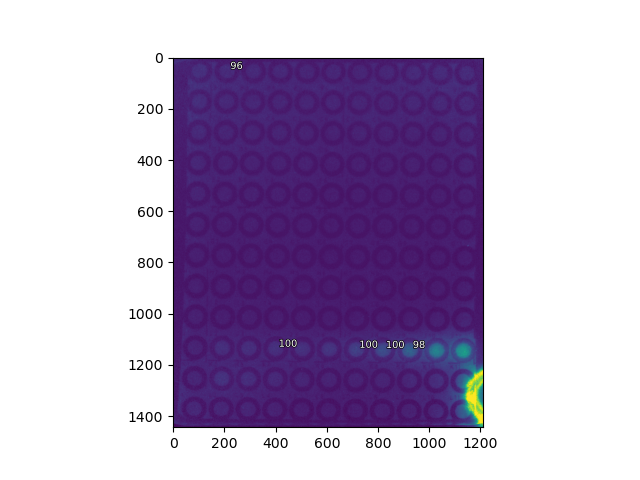

In [14]:
# Detect Halos using the halo.detect method.
halos,recon,bin_recon,skel,halo_hough=msu.halo.detect(
    img=raw_img,
    min_rad=40,
    max_rad=100,
    min_xdist=38,
    min_ydist=38,
    thresh=0.2,
    min_obj_size=800,
    troubleshoot=True,
    dil_disk=10
    )

# Assign halos to their spot.
for s in sort_spots:
    s.assign_halo(
        halos,
        dist_thresh=15
        )

fig,axs=plt.subplots()

axs.imshow(raw_img)

df=msu.spot.create_df(sort_spots)

halo_df=df[df["halo"]>0]
for idx in halo_df.index:
    axs.text(halo_df.loc[idx,"x_coord"]+12, halo_df.loc[idx,"y_coord"]-9, f'{halo_df.loc[idx,"halo"]:.0f}',c="white",size=7,path_effects=[pe.withStroke(linewidth=1, foreground="k")])

# fig,ax=plt.subplots(2,2,figsize=(10,10))
# ax[0,0].imshow(recon)
# ax[0,1].imshow(bin_recon)
# ax[1,0].imshow(skel)


## Normalization using Controls

Spot-Intensities will be normalized using the spots marked as `"Control"`.

In [15]:
# If controls are present, normalize the spot intensities 
if len(control_spots) != 0:
    msu.spot.normalize(sort_spots)

## Scaling of Halo

Please choose one of the options below. It is recommended to only scale halo data to the intensities of spots that have been normalized. 

The scaling is done to bring the antimicrobial halo radii in line with the optical read-out of the assay to yield semi-quantitative results for spots containing halos.

In [16]:
# # Scale to raw spot intensities (Not recommended!!)
# for s in sort_spots:
#     if s.halo > 0:
#         s.int=s.halo/30

In [17]:
# Scale to normalized spot intensities (Recommended!!)
for s in sort_spots:
    if s.halo > 0:
        s.norm_int=s.halo/25

## Results

Plots of the Results are displayed here.

,row,row_name,column,type,x_coord,y_coord,radius,halo,spot_intensity,norm_intensity,note,RT
0,1,A,1,Control,105,52,24,NaN,0.461616,1.044378,Initial Detection,NaN
1,1,A,2,Sample,211,53,25,96.0,0.452249,3.840000,Initial Detection,NaN
2,1,A,3,Sample,315,53,24,NaN,0.448922,1.015659,Initial Detection,NaN
3,1,A,4,Sample,419,56,25,NaN,0.446810,1.010881,Initial Detection,NaN
4,1,A,5,Sample,524,56,25,NaN,0.442196,1.000441,Initial Detection,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
127,12,L,7,Sample,714,1380,23,NaN,0.427553,0.967313,Initial Detection,NaN
128,12,L,8,Sample,813,1381,23,NaN,0.430455,0.973877,Initial Detection,NaN
129,12,L,9,Sample,921,1383,25,NaN,0.434086,0.982093,Initial Detection,NaN
130,12,L,10,Sample,1025,1382,23,NaN,0.446074,1.009216,Initial Detection,NaN


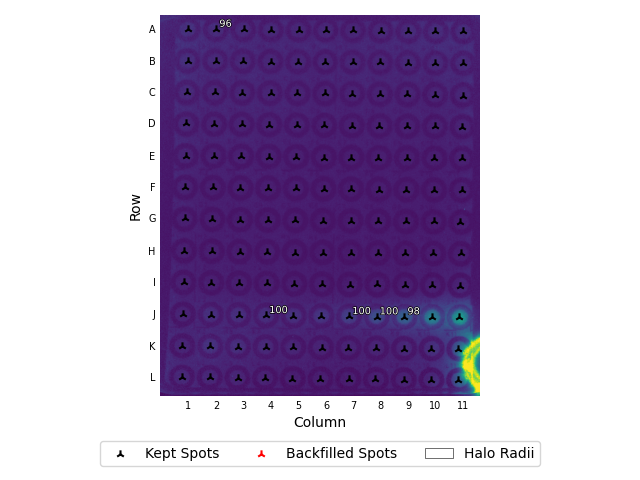

In [18]:
# Display the corrected and sorted spotlist.
sort_spot=msu.spot.create_df(sort_spots)

fig,ax=plt.subplots()
plots.plot_result(fig,ax,raw_img,sort_spot,grid_props)

sort_spot


### Heatmap

If you did not normalize your data change the `value_col` argument to `"spot_intensity"`. If you performed halo detection set the `halo` argument to `True`.

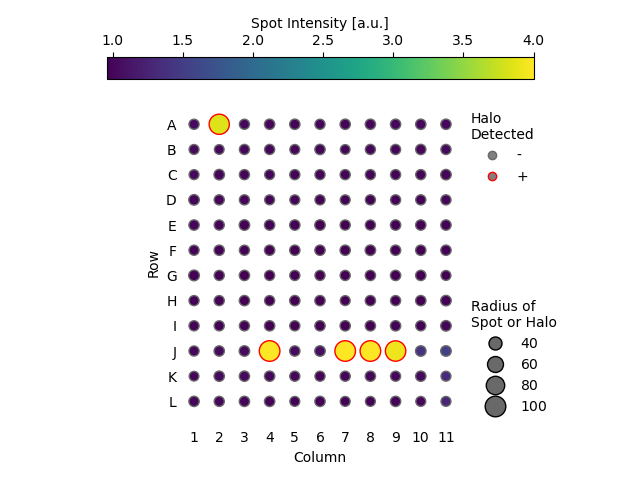

: 

In [21]:
fig,ax=plt.subplots()
plots.plot_heatmapv2(
    fig,
    ax,
    df=sort_spot,
    conv_dict=row_conv_inv,
    value_col="norm_intensity",
    colorbar_name="Spot Intensity [a.u.]",
    halo=False
)

## Save Results

In [ ]:
# Create the output-folder if it does not exist already
if not outputfolder.exists():
    outputfolder.mkdir()

# Generate path for output-file
filename=inputfile.name.split(".")[0]+"_spotlist.csv"
outputfile=outputfolder/filename

# Write a csv-file of the results.
sort_spot.to_csv(outputfile)